In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
import simtk.openmm as mm
from torsionfit import TorsionScanSet as ScanSet
import torsionfit.TorsionFitModel as Model
from torsionfit import sqlite_plus
from pymc import MCMC
from parmed.charmm import CharmmParameterSet
from torsionfit import plots
from matplotlib.backends.backend_pdf import PdfPages
from torsionfit import utils
#import seaborn as sbn
import numpy as np

In [2]:
db = sqlite_plus.load('butane_all_n5_100000.db')

In [3]:
from torsionfit import plots


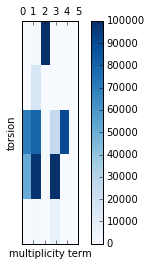

In [6]:
multiplicities = tuple(range(1, 7))
mult_bitstring = []
for key in db.getstate()['stochastics']:
    key_split = key.split('_')
    if key_split[-1] == 'bitstring':
        mult_bitstring.append(key)

histogram = np.zeros((len(mult_bitstring), 100000, 6))

for m, torsion in enumerate(mult_bitstring):
    for i, j in enumerate(db.trace('%s' % torsion)[:]):
        for k, l in enumerate(multiplicities):
            if 2**(l-1) & int(j):
                histogram[m][i][k] = 1

plt.matshow(histogram.sum(1), cmap='Blues',  extent=[0, 5, 0, 20]), plt.colorbar()
plt.yticks([])
plt.xlabel('multiplicity term')
plt.ylabel('torsion')


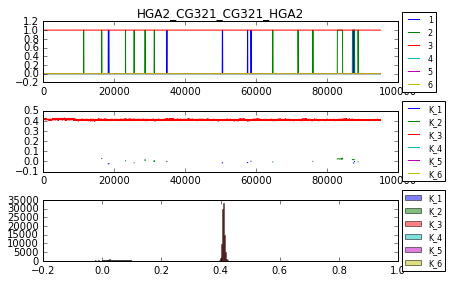

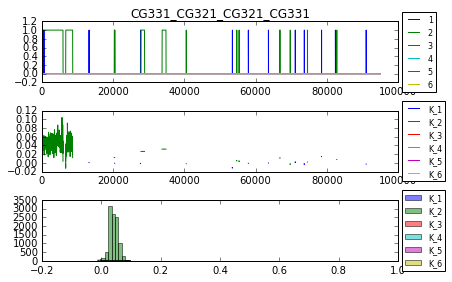

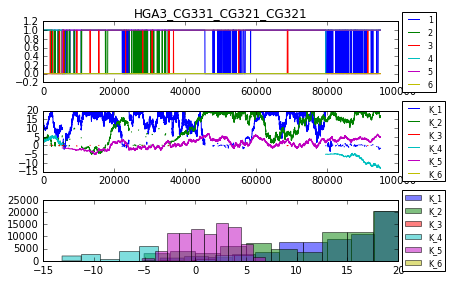

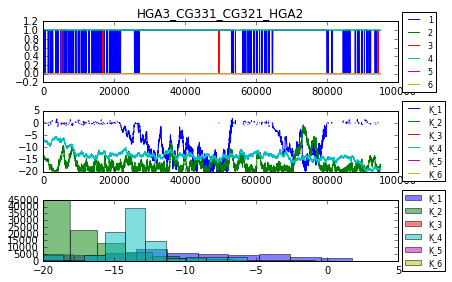

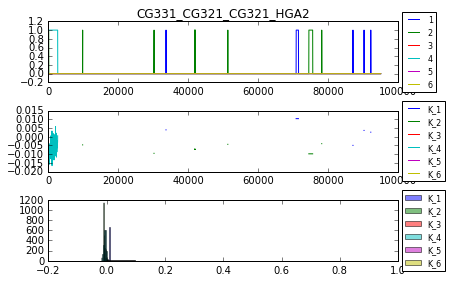

In [8]:
alpha=0.5               
with PdfPages('hist_traces_all.pdf') as pdf:
    for i, mult in enumerate(mult_bitstring):
        plt.figure()
        t_name = mult.split('_')[:-2]
        for m in multiplicities:
            name = t_name[0] + '_' + t_name[1] + '_' + t_name[2] + '_' + t_name[3] + '_' + str(m) + '_K'
            plt.subplot(3, 1, 1)
            plt.title('{}'.format(name[:-4]))
            plt.plot(histogram[i, 5000:, m-1], label=str(m))
            plt.ylim(-0.2, 1.2)
            lgd = plt.legend(prop={'size': 8}, loc='center left', bbox_to_anchor=(1, 0.5))
            trace = db.trace(name)[5000:]
            index_0 = np.where(histogram[i, 5000:, m-1] == 0)
            index_1 = np.where(histogram[i, 5000:, m-1] == 1)
            np.place(trace, histogram[i, 5000:, m-1] == 0, np.ones(len(index_0[0]))*np.nan)
            plt.subplot(3, 1, 2)
            plt.plot(trace, label='K_{}'.format(m))
            lgd = plt.legend(prop={'size': 8}, loc='center left', bbox_to_anchor=(1, 0.5))
            plt.subplot(3, 1, 3)
            plt.hist(trace[index_1], label='K_{}'.format(m), alpha=alpha)
            lgd = plt.legend(prop={'size': 8}, loc='center left', bbox_to_anchor=(1, 0.5))
            plt.tight_layout()
        pdf.savefig(bbox_extra_artists=(lgd,), bbox_inches='tight')